<a href="https://colab.research.google.com/github/Jake-BS/dissertation_code/blob/main/Dissertation_Code_Grid_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Config options**

`backupDir` Set to a folder in your gdrive so that trained weights are saved even if the runtime times out.

`resume` Continue training based on any existing weights files in `backupDir`.

`color` Disable hue augmentation if you want the network to use colour as part of the classification decisions.

`tiny` Use the tiny version of yolo. Faster to train and run but less accurate.

`yolo` Set yolo version to use, 3 or 4 supported at present.

In [ ]:
resume = False             # resume training that was previously stopped
color = True              # use color for classification
tiny = True               # train tiny yolo model
yolo = 4                 # yolo version to use
trainProp = 0.6           # proportion of images to use for training - changed from 6 to 8
testProp = 0.2
multiplier = 1            # training multiplier, train beyond 'recommeneded'
colabFree = False         # if using a free version of colab this might be required

datasetFile = "/content/gdrive/MyDrive/Dissertation/the_cones.tar.gz"
backupDir = "/content/gdrive/MyDrive/Dissertation/backupgridsearch"
classesFile = "/content/gdrive/MyDrive/Dissertation/classes.txt"

# You probably don't need to touch anything below this line
rebuild = False           # recompile darknet, set to true if you have changed any of the options below
size = None, None         # change network input size, set as None, None to use the default

#if yolo == 4: size = 416, 416
size = 416, 416

# try it out
#size = 416, 736

# input size must be multiple of 32
assert( size[0]%32 == 0 )
assert( size[1]%32 == 0 )

validProp = 1 - trainProp - testProp

gpu_info = !nvidia-smi   # automatically detect if you are using a gpu runtime
gpu = '\n'.join(gpu_info).find('failed') == -1

tensor = True
opencv = True
cudnn = True

import os

wrkDir = "/content"

tempDir = os.path.join( wrkDir, "temp" )
dataDir = os.path.join( wrkDir, "data" )
yoloDir = os.path.join( wrkDir, "yolo" )
#What should this file be?
darknetDir = os.path.join( wrkDir, "darknet" )
trainingDir = os.path.join(yoloDir, "training")

dataFile = os.path.join(yoloDir, "obj.data")
namesFile = os.path.join(yoloDir, "obj.names")
trainingFile = os.path.join(yoloDir, "train.txt")
testingFile = os.path.join(yoloDir, "test.txt")
validFile = os.path.join(yoloDir, "valid.txt")
trainingCfgFile = os.path.join(yoloDir, "training.cfg")
trainedCfgFile = os.path.join(yoloDir, "trained.cfg")
weightsFile = os.path.join(yoloDir,"yolo.weights")
trainedWeightsFile = os.path.join( backupDir, "training_best.weights" )


In [ ]:
# display config options
print( f"colabFree  = {colabFree}" )
print( f"color      = {color}" )
print( f"cudnn      = {cudnn}" )
print( f"gpu        = {gpu}" )
print( f"multiplier = {multiplier}" )
print( f"opencv     = {opencv}" )
print( f"rebuild    = {rebuild}" )
print( f"resume     = {resume}" )
print( f"size       = {size}" )
print( f"tensor     = {tensor}" )
print( f"testProp   = {testProp}" )
print( f"tiny       = {tiny}" )
print( f"trainProp  = {trainProp}" )
print( f"validProp  = {validProp}" )
print( f"yolo       = {yolo}" )
print()

print( f"tempDir     = {tempDir}" )
print( f"dataDir     = {dataDir}" )
print( f"yoloDir     = {yoloDir}" )
print( f"darknetDir  = {darknetDir}" )
print( f"trainingDir = {trainingDir}" )
print( f"backupDir   = {backupDir}" )
print()

print( f"dataFile           = {dataFile}" )
print( f"namesFile          = {namesFile}" )
print( f"trainingFile       = {trainingFile}" )
print( f"testingFile        = {testingFile}" )
print( f"trainingCfgFile    = {trainingCfgFile}" )
print( f"trainedCfgFile     = {trainedCfgFile}" )
print( f"trainedWeightsFile = {trainedWeightsFile}" )
print( f"validFile          = {validFile}" )
print( f"weightsFile        = {weightsFile}" )

colabFree  = False
color      = True
cudnn      = True
gpu        = True
multiplier = 1
opencv     = True
rebuild    = False
resume     = False
size       = (416, 416)
tensor     = True
testProp   = 0.2
tiny       = True
trainProp  = 0.6
validProp  = 0.2
yolo       = 4

tempDir     = /content/temp
dataDir     = /content/data
yoloDir     = /content/yolo
darknetDir  = /content/darknet
trainingDir = /content/yolo/training
backupDir   = /content/gdrive/MyDrive/Dissertation/backupgridsearch

dataFile           = /content/yolo/obj.data
namesFile          = /content/yolo/obj.names
trainingFile       = /content/yolo/train.txt
testingFile        = /content/yolo/test.txt
trainingCfgFile    = /content/yolo/training.cfg
trainedCfgFile     = /content/yolo/trained.cfg
trainedWeightsFile = /content/gdrive/MyDrive/Dissertation/backupgridsearch/training_best.weights
validFile          = /content/yolo/valid.txt
weightsFile        = /content/yolo/yolo.weights


# Mount your google drive, and extract the contents of your dataset .zip

In [ ]:
        #mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
#!ln -s "/content/gdrive/My Drive/" /mydrive

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!rm -r {tempDir}
!mkdir -p {tempDir}
#!unzip -qo {datasetFile} -d {tempDir}
!tar -xf {datasetFile} --directory {tempDir}
!ls {tempDir}

the_cones


## Move all image and text files from the extract directory into the data directory.

So we don't have to deal with different directory structures going forwards

In [ ]:
import glob, os, shutil

try: shutil.rmtree( dataDir )
except FileNotFoundError: pass

os.makedirs( dataDir )

# find and relocate all images
print( f"Move contents of {tempDir}")

for ext in ('*.png', '*.jpg', "*.txt"):
  globPath = os.path.join( tempDir, "**", ext )
  print( globPath )
  for filename in glob.glob( globPath, recursive=True ):
    print( filename )
    shutil.copyfile( filename, os.path.join( dataDir, os.path.split(filename)[-1] ) )

Move contents of /content/temp
/content/temp/**/*.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left001740.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left002240.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left003100.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left003300.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left002340.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left003240.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_many_left000020.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left002320.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left002220.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left002360.png
/content/temp/the_cones/05_david_done/HD1080_zed_wet_behind_ecb_few_left002620.png
/content/temp/the_cones/05_david

## Check dataset is valid

- Classes file is present and readable.
- Images are jpgs (convert if needed).
- Images have matching labels.
- Label files are correctly formatted.

In [ ]:
# name your classes
#classes = ["blue","orange","yellow"]
with open( os.path.join(dataDir, classesFile), "r" ) as f:
  classes = [ i.strip() for i in f ]

print( classes )

['blue', 'orange', 'yellow']


In [ ]:
#convert pngs to jpg
#!apt install -y imagemagick

import os, glob, re
import cv2

# convert pngs
for filename in glob.glob( f"{dataDir}/*.png" ):
  print( f"Convert {filename}" )
  #os.system( f'convert "{filename}" "{filename.replace(".png",".jpg")}"' )
  #os.remove( filename )
  image = cv2.imread( filename )
  if image is None:
    print( f"Failed to open {filename}" )
  else:
    cv2.imwrite( ".".join(filename.split(".")[:-1])+".jpg", image )
  os.remove( filename )

# check label file exists
for filename in glob.glob( f"{dataDir}/*.jpg" ):
  if not os.path.exists( filename.replace( ".jpg", ".txt" ) ):
    print( f"Missing labels {filename}" )
    os.remove( filename )

# confirm images are valid
#for filename in glob.glob( f"{dataDir}/*.jpg" ):
#  result = os.system( f"identify -format '%f' '{filename}'" )
#  if result:
#      print( f"Identify fail {filename}" )
      #os.remove( filename )

# confirm that label files are in correct format
yoloReg = re.compile( r"^(\s*([0-9]{1,})\s{1,}(\S{1,})\s{1,}(\S{1,})\s{1,}(\S{1,})\s{1,}(\S{1,})\s*|\s*)$" )
for filename in glob.glob( f"{dataDir}/*.txt" ):
  if filename.endswith( classesFile ): continue

  valid = True
  with open( filename, "r" ) as f:
    for line in f:
      matches = yoloReg.match( line ).groups()
      
      c = int(matches[1])
      if c<0 or c>=len(classes): valid = False
      else:
        for i in matches[-4:]:
          i = float(i)
          if i<0 or i>1: valid = False

  if not valid:
    print( f"{filename} is invalid" )
    os.remove( filename )
    os.remove( filename.replace(".txt", ".jpg") )


Convert /content/data/HD1080_zed2_cloud_road_few_left000120.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left001740.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left002240.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left003100.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left000600.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left000720.png
Convert /content/data/HD1080_zed2_sunny_behind_ecb_few_left001080.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left003300.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left002340.png
Convert /content/data/HD1080_zed2_sunny_behind_ecb_few_left000860.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left003240.png
Convert /content/data/HD1080_zed_wet_behind_ecb_many_left000020.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left002320.png
Convert /content/data/HD1080_zed_wet_behind_ecb_few_left000480.png
Convert /content/data/HD1080_zed2_sunny_library_few_left00

# **Clone `darknet` git repository** 

Needed now as we are about to start generating the configuration files based on the default ones


In [ ]:
if not os.path.exists( darknetDir ) or rebuild:
  try: shutil.rmtree( darknetDir )
  except FileNotFoundError: pass

  !git clone https://github.com/AlexeyAB/darknet {darknetDir}

  #os.system( f"git clone https://github.com/AlexeyAB/darknet {darknetDir}" )

  #!git clone https://github.com/leggedrobotics/darknet /content/darknet
  #!git clone https://github.com/pjreddie/darknet {darknetDir}

## Create config files


In [ ]:
try: shutil.rmtree( yoloDir )
except FileNotFoundError: pass

os.makedirs( yoloDir )

print( f"Create {dataFile}" )
with open( dataFile, "w" ) as f:
  f.write( f"classes = {len(classes)}\n" )
  f.write( f"train = {trainingFile}\n" )
  f.write( f"test = {testingFile}\n" )
  f.write( f"valid = {validFile}\n" )
  f.write( f"names = {namesFile}\n" )
  f.write( f"backup = {backupDir}\n" )
!cat {dataFile}

print( f"Create {namesFile}" )
with open( namesFile, "w" ) as f:
  for i in classes:
    f.write( f"{i}\n" )

Create /content/yolo/obj.data
classes = 3
train = /content/yolo/train.txt
test = /content/yolo/test.txt
valid = /content/yolo/valid.txt
names = /content/yolo/obj.names
backup = /content/gdrive/MyDrive/Dissertation/backupgridsearch
Create /content/yolo/obj.names


In [ ]:
# split the images into testing and training groups
# assuming that similar images have similar files names, this approach ensures
# a representative distribution between the groups and will produce the same
# split every time

import math, os

files = sorted( [ i for i in os.listdir( dataDir ) if i.endswith(".jpg") ] )

buckets = ( [ open( trainingFile, "w" ), 0, trainProp ],
			      [ open( testingFile, "w" ), 0, testProp ], 
			      [ open( validFile, "w" ), 0, validProp ] )

for img in files:
  s = sorted( buckets, key=lambda i: i[1] / (len(files)*i[2]) if i[2] else math.inf )

  s[0][1] += 1
  s[0][0].write( f"{os.path.join(dataDir,img)}\n" )

for f, count, _ in buckets:
  print( count )
  f.close()


459
154
153


## **Generate network config files**


In [ ]:
def setParameters(width, height, angle, saturation, hue, blur, momentum, decay, learning, os, exposure):
  import os, re

  # how many training images have we got
  try:
    with open(trainingFile, 'r') as f:
      images = sum( ( 1 for i in f if i.strip() != "" ) )
  except:
    images = 1000

  #The below switch statement can be used to chose which test config file to run
  sourceFiles = { (3,True):  os.path.join( darknetDir, "cfg", "yolov3-tiny.cfg" ),
                  (3,False): os.path.join( darknetDir, "cfg", "yolov3.cfg" ),
                  (4,True):  os.path.join( darknetDir, "cfg", "yolov4-tiny-custom.cfg" ),
                  (4,False): os.path.join( darknetDir, "cfg", "yolov4-custom.cfg" )}
 
  #maxBatches = max(len(classes)*2000,images,6000) * multiplier
  maxBatches = 1000
  steps = int(maxBatches*0.8), int(maxBatches*0.9)
  replacements = [ 
    ( r"^\s*batch\s*=\s*[0-9]{1,}",        f"batch={[64,32][colabFree]}\n" ),
    ( r"^\s*subdivisions\s*=\s*[0-9]{1,}", f"subdivisions={[16,8][colabFree]}\n" ),
    ( r"^\s*max_batches\s*=\s*[0-9]{1,}", f"max_batches={maxBatches}\n" ),
    ( r"^\s*steps\s*=\s*[0-9,]{3,}",      f"steps={steps[0]},{steps[1]}\n" ),
    ( r"^\s*classes\s*=\s*[0-9]{1,}",     f"classes={len(classes)}\n" ),
    ( r"^\s*filters\s*=\s*255",           f"filters={(len(classes)+5)*3}\n" ),
    #My replacements are below
    ( r"^\s*width\s*=\s*[0-9]{1,}", f"width={width}\n" ),
    ( r"^\s*height\s*=\s*[0-9]{1,}", f"height={height}\n" ),
    ( r"^\s*angle\s*=\s*[0-9]{1,}", f"angle={angle}\n" ),
    #Below parameters have decimal values so added .[0-9] after [0-9]
    ( r"^\s*saturation\s*=\s*[0-9].[0-9]{1,}", f"saturation={saturation}\n" ),
    ( r"^\s*exposure\s*=\s*[0-9].[0-9]{1,}", f"exposure={exposure}\n" ),
    ( r"^\s*hue\s*=\s*[0-9].[0-9]{1,}", f"hue={0}\n" ),
    ( r"^\s*momentum\s*=\s*[0-9].[0-9]{1,}", f"momentum={momentum}\n" ),
    ( r"^\s*decay\s*=\s*[0-9].[0-9]{1,}", f"decay={decay}\n" ),
    ( r"^\s*learning_rate\s*=\s*[0-9].[0-9]{1,}", f"learning_rate={learning}\nblur={blur}\n" ),
    ]

  altReplacements = [
    ( r"^\s*batch=64", "batch=1\n" ),
    ( r"^\s*batch=32", "batch=1\n" ),
    ( r"^\s*subdivision=16", "subdivision=1\n" ),
    ( r"^\s*subdivision=8", "subdivision=1\n" )
    ]

  # will colour be used for discrimination?
  '''
  if color:
    replacements.append( ( r"^hue=\.1", "hue=0\n" ) )

  if size[0] != None:
    assert size[0] % 32 == 0
    replacements.append( ( r"^\s*height\s*=\s*[0-9]{1,}",
                         f"height={int(size[0]/32)*32}\n" ) )

  if size[1] != None:
    assert size[1] % 32 == 0
    replacements.append( ( r"^\s*width\s*=\s*[0-9]{1,}",
                          f"width={int(size[1]/32)*32}\n" ) )
  '''

  replacements = [ ( re.compile( i ), j ) for i, j in replacements ]
  altReplacements = [ ( re.compile( i ), j ) for i, j in altReplacements ]

  sourceFilename = sourceFiles[ (yolo,tiny) ]
  print( f"Using {sourceFilename} as source file ")
  with open( sourceFilename, "r" ) as i:
    with open( trainingCfgFile, "w" ) as o:
      with open( trainedCfgFile, "w" ) as o2:
        for line in i:
          before = line
          for reg, rep in replacements:
            if reg.match( line ):
              line = rep
          o.write( line )

          if line != before: print( line, end="" )

          for reg, rep in altReplacements:
            if reg.match( line ):
              line = rep
          o2.write( line )
  # change makefile to have GPU and OPENCV enabled
  # also set CUDNN, CUDNN_HALF and LIBSO to 1

  replacements = [ 
    ( r"^\s*LIBSO=0",       "LIBSO=1\n" )
    ]

  if opencv:
    replacements.append( ( r"OPENCV=0", "OPENCV=1\n" ) )

  if gpu:
    replacements.append( ( r"^\s*GPU=0", "GPU=1\n" ) )

    if cudnn:
      replacements.append( ( r"^\s*CUDNN=0",       "CUDNN=1\n" ) )

    if tensor:
      replacements.append( ( r"^\s*CUDNN_HALF=0",  "CUDNN_HALF=1\n" )  )

  replacements = [ ( re.compile( i ), j ) for i, j in replacements ]

  print( f"Edit {darknetDir}" )

  with open( os.path.join( darknetDir, "Makefile" ), "r" ) as i:
    contents = i.readlines()

  with open( os.path.join( darknetDir, "Makefile" ), "w" ) as o:
    for line in contents:
      #print( line )
      for reg, rep in replacements:
        if reg.match( line ):
          line = rep
      o.write( line )
  return os

def buildDarknet(os):
  if not os.path.exists( os.path.join( darknetDir, "darknet" ) ) or rebuild:
    #os.system( f"make -C {darknetDir}" )
    !make -C {darknetDir}
  return os

def downloadPTYoloWeights(os):
  import shutil

  lastWeightsFile = os.path.join( backupDir, "training_last.weights" )

  #Need to keep an eye on this between different tests
  if not resume or not os.path.exists( lastWeightsFile ): # resumt is False or the last weights don't exist
    print( "Download pre-trained weights" )
    if yolo == 4 and tiny:
      url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29"
    elif yolo == 4 and not tiny:
      url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137"
    elif yolo == 3 and not tiny:
      url = "https://pjreddie.com/media/files/darknet53.conv.74"

    print( url )
    os.system( f"wget {url} -O {weightsFile}" )
    #added code from else statement below
    %cd {darknetDir}
    #If you want to train from the beginning, then use flag in the end of training command: -clear 
    cmd = f"./darknet detector train {dataFile} {trainingCfgFile} {weightsFile} -dont_show -map -clear | tee -a {os.path.join(backupDir, 'darknet.log')}"
    print( cmd )
    !{cmd}
  else:
    print( "Resuming" )

    shutil.copyfile( lastWeightsFile, weightsFile )
    import os

    !mkdir -p {backupDir}
    !cp -r {yoloDir} {backupDir}/.
  
    %cd {darknetDir}

    #If you want to train from the beginning, then use flag in the end of training command: -clear 
    cmd = f"./darknet detector train {dataFile} {trainingCfgFile} {weightsFile} -dont_show -map | tee -a {os.path.join(backupDir, 'darknet.log')}"
    print( cmd )
    !{cmd}
    #only works if the training does not get interrupted

def errorBreak():
  # This stops 'Run all' at this cell by causing an error
  assert False
  

# define helper function imShow
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  return os

def checkMAP():
  !./darknet detector map {dataFile} {trainedCfgFile} {trainedWeightsFile} 2>&1 | egrep "class_id|conf_thresh|IoU|mean average"

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.000000), count: 1, class_loss = 0.000069, iou_loss = 0.000000, total_loss = 0.000069 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.612652), count: 30, class_loss = 2.785261, iou_loss = 282.001556, total_loss = 284.786804 
 total_bbox = 458135, rewritten_bbox = 7.380357 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.633106), count: 2, class_loss = 0.369573, iou_loss = 0.279398, total_loss = 0.648971 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.596697), count: 20, class_loss = 1.739608, iou_loss = 187.720139, total_loss = 189.459747 
 total_bbox = 458157, rewritten_bbox = 7.380221 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.705964), count: 2, class_loss = 0.148625, iou_loss = 0.234725, total_loss = 0.38334

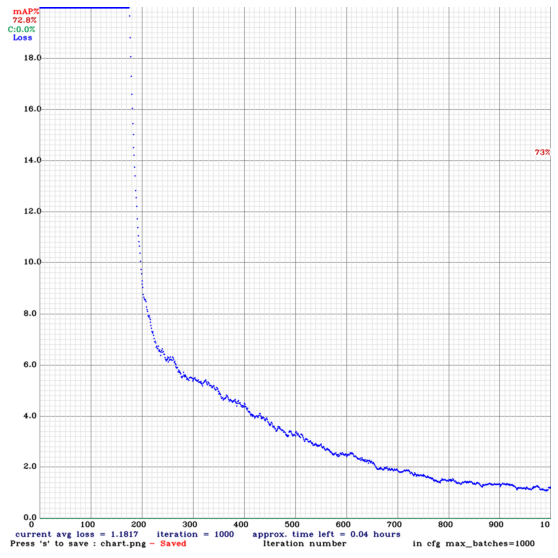

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.668815), count: 1, class_loss = 0.248159, iou_loss = 0.051472, total_loss = 0.299631 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.743204), count: 19, class_loss = 0.527466, iou_loss = 163.352020, total_loss = 163.879486 
 total_bbox = 460723, rewritten_bbox = 7.205197 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.000000), count: 1, class_loss = 0.000443, iou_loss = 0.000000, total_loss = 0.000443 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.691118), count: 19, class_loss = 2.292407, iou_loss = 108.689598, total_loss = 110.982002 
 total_bbox = 460742, rewritten_bbox = 7.204900 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.522959), count: 1, class_loss = 0.003413, iou_loss = 0.149236, total_loss = 0.15264

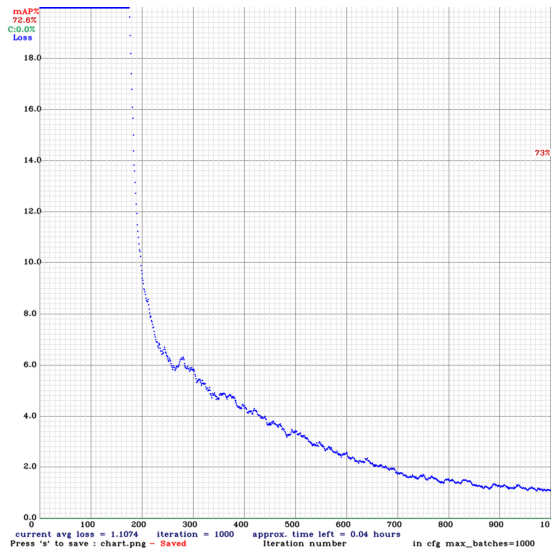

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.000000), count: 1, class_loss = 0.098515, iou_loss = 0.000000, total_loss = 0.098515 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.775967), count: 15, class_loss = 1.140142, iou_loss = 33.944195, total_loss = 35.084335 
 total_bbox = 461192, rewritten_bbox = 7.341194 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.502525), count: 3, class_loss = 0.211652, iou_loss = 0.354307, total_loss = 0.565958 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.702665), count: 14, class_loss = 0.498678, iou_loss = 78.463951, total_loss = 78.962631 
 total_bbox = 461209, rewritten_bbox = 7.341140 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.411008), count: 1, class_loss = 0.217566, iou_loss = 0.092263, total_loss = 0.309829 
v

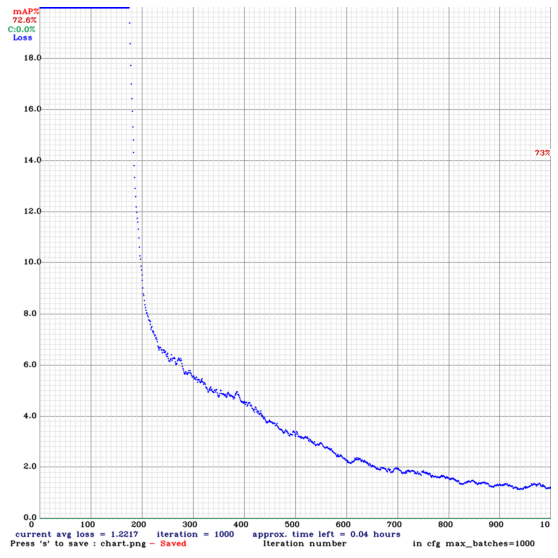

 calculation mAP (mean average precision)...
class_id = 0, name = blue, ap = 76.01%   	 (TP = 345, FP = 83) 
class_id = 1, name = orange, ap = 73.53%   	 (TP = 187, FP = 84) 
class_id = 2, name = yellow, ap = 68.29%   	 (TP = 500, FP = 230) 
 for conf_thresh = 0.25, precision = 0.72, recall = 0.74, F1-score = 0.73 
 for conf_thresh = 0.25, TP = 1032, FP = 397, FN = 369, average IoU = 52.56 % 
 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.726136, or 72.61 % 


In [ ]:
#Random Search of chosen yolov4.config file parameters
def getPList(startValue, endValue, incrementValue):
  pList = []
  currentValue = startValue
  for i in range(int((endValue-startValue)/incrementValue)):
    pList.append(currentValue)
    currentValue+=incrementValue
  return pList

from random import choice
#nOfModels decides how many times you run the random search
#The higher the value of this variable, the higher the chance of getting a good correlation is
nOfModels = 3
#resultsList = []

#[net] Section
widthHeightList = getPList(448, 768, 32)
#Data augmentation
angleList = getPList(18, 198, 18)
saturationList = getPList(2.5, 12.5, 2.5)
exposureList = getPList(2.5, 12.5, 2.5)
hueList = getPList(0.25, 1.25, 0.25)
blurList = getPList(0.1, 1.1, 0.1)
#Optimizer
momentumList = getPList(0.1, 1.1, 0.1)
decayList = getPList(0.0001, 0.0011, 0.0001)
learningList = getPList(0.002, 0.003, 0.0001)

for i in range(nOfModels):
  #width = widthHeightList[i]
  width = 608

  #height = widthHeightList[i]
  height = 608

  #angle = angleList[i]
  angle = 0

  #saturation = saturationList[i]
  saturation = 1.5

  #hue = hueList[i]
  hue = 0.1

  #blur = blurList[i]
  blur=0
  
  #momentum = momentumList[i]
  momentum=0.9

  #decay = decayList[i]
  decay=0.0005

  #learning = learningList[i]
  learning = 0.0013

  exposure = 1.5

  pLog = backupDir + "/parameters.log"
  

  os = setParameters(width, height, angle, saturation, hue, blur, momentum, decay, learning, os, exposure)
  os = buildDarknet(os)
  downloadPTYoloWeights(os)
  imShow('chart.png')
  checkMAP()
  with open(pLog, "a") as f:
    f.write(str(width) + ", " + str(height) + ", " + str(angle) + ", " + str(saturation) + ", " + str(hue) + ", " + str(blur) + ", " + str(momentum) + ", " + str(decay) + ", " + str(learning) + ", " + str(exposure) + "\n")
  #f1Score = ...
  #currentOptions = [f"Combination number {i}", width, height, angle, saturation, hue, blur, momentum, decay, learning]
  #resultsList.append(currentOptions)

In [ ]:
backupDir = "/content/gdrive/MyDrive/Dissertation/backupgridsearch"
import re

def logReader(filename):
  with open(filename) as f:
    log = f.read()
    regex = r'F1-score = 0.\d{1,5}|F1-score = -nan'
    f1List = re.findall(regex, log)
    return f1List
log = backupDir + "/darknet.log"
f1StringList = logReader(log)
f1List = []
for f1String in f1StringList:
  f1List.append(float(f1String[11:]))


len(f1List)

15

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st


In [ ]:
widthChosenList = []
heightChosenList = []
angleChosenList = []
saturationChosenList = []
hueChosenList = []
blurChosenList = []
momentumChosenList = []
decayChosenList = []
learningChosenList = []
exposureChosenList =[]
def paraReader(filename):
  with open(filename, "r") as f:
    log = f.readlines()
    paraListList = []
    for i in range(len(log)):
      log[i]=log[i][:-1]
      paraListList.append(log[i].split(", "))
    return paraListList
paraListList=paraReader(backupDir + "/parameters.log")
for i in paraListList:
  widthChosenList.append(float(i[0]))
  heightChosenList.append(float(i[1]))
  angleChosenList.append(float(i[2]))
  saturationChosenList.append(float(i[3]))
  hueChosenList.append(float(i[4]))
  blurChosenList.append(float(i[5]))
  momentumChosenList.append(float(i[6]))
  decayChosenList.append(float(i[7]))
  learningChosenList.append(float(i[8]))
  exposureChosenList.append(float(i[9]))
len(paraListList)

15

In [ ]:
def plotLR(f1s, parameters, xLabel, yLabel):
  reg = np.polyfit(parameters, f1s, deg=1)
  trend = np.polyval(reg, parameters)
  plt.scatter(parameters, f1s)
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  plt.plot(parameters, trend, 'r')

from sklearn.linear_model import LinearRegression # to build a LR model for comparison
from sklearn.preprocessing import PolynomialFeatures
def plotPolyR(y, x):
  x= np.array(x).reshape(-1, 1)
  poly = PolynomialFeatures(degree=3)
  X_poly = poly.fit_transform(x)
  poly.fit(X_poly, y)
  linreg = LinearRegression()
  linreg.fit(X_poly, y)
  y_pred=linreg.predict(X_poly)
  plt.scatter(x,y, color='blue')
  plt.plot(x,y_pred, color='red')
#plotLR(f1List, widthChosenList)
#np.corrcoef(f1List, widthChosenList)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

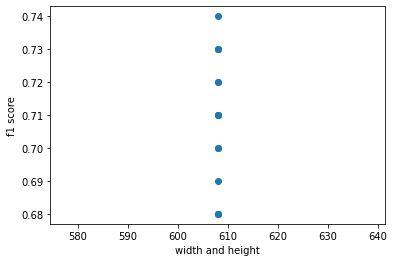

In [ ]:
plotLR(f1List, heightChosenList, "width and height", "f1 score")
np.corrcoef(f1List, heightChosenList)

In [ ]:
#plotLR(f1List, angleChosenList)
#np.corrcoef(f1List, angleChosenList)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

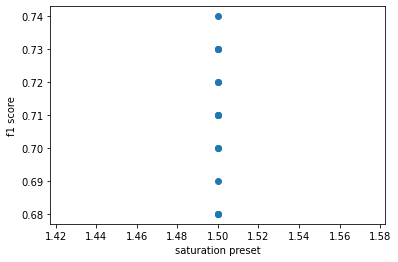

In [ ]:
plotLR(f1List, saturationChosenList, "saturation preset", "f1 score")
np.corrcoef(f1List, saturationChosenList)

array([[ 1.        , -0.43396492],
       [-0.43396492,  1.        ]])

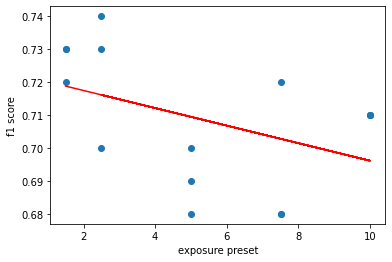

In [ ]:
plotLR(f1List, exposureChosenList, "exposure preset", "f1 score")
np.corrcoef(f1List, exposureChosenList)

In [ ]:
aplotLR(f1List, blurChosenList, "blur", "f1 score")
np.corrcoef(f1List, blurChosenList)

NameError: ignored

In [ ]:
f1List.pop(9)
f1List.pop(18)
f1List.pop(27)
momentumChosenList.pop(9)
momentumChosenList.pop(18)
momentumChosenList.pop(27)
plotLR(f1List, momentumChosenList, "momentum", "f1 score")
np.corrcoef(f1List, momentumChosenList)

In [ ]:
plotLR(f1List, decayChosenList, "decay", "f1 score")
np.corrcoef(f1List, decayChosenList)

In [ ]:
plotLR(f1List, learningChosenList, "learning rate", "f1 score")
np.corrcoef(f1List, learningChosenList)

In [ ]:
bestF1 = max(f1List)
bestIndex = f1List.index(bestF1)
len(f1List)